In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout

In [2]:
data_dir =r"E:\1. Thesis\PDD_MangoLeaf\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [3]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

#### Modified BatchSize=32, split=60%+20%+20%, targetSize=128,128, lr=.00001

In [4]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [5]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [6]:
num_classes=8
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable=True
#inputs=base_model.input
inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=False)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 4, 4, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,438,024 (230.55 MB)

 Trainable params: 60,294,280 (230.00 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [8]:
epochs=10
training_history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2123s 25s/step - accuracy: 0.2716 - loss: 1.9873 - val_accuracy: 0.6062 - val_loss: 1.2557
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1603s 21s/step - accuracy: 0.7493 - loss: 1.0773 - val_accuracy: 0.8438 - val_loss: 0.5257
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2117s 28s/step - accuracy: 0.8922 - loss: 0.5498 - val_accuracy: 0.9262 - val_loss: 0.2441
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1526s 20s/step - accuracy: 0.9454 - loss: 0.2839 - val_accuracy: 0.9563 - val_loss: 0.1443
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1563s 21s/step - accuracy: 0.9635 - loss: 0.1861 - val_accuracy: 0.9800 - val_loss: 0.0908
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2211s 29s/step - accuracy: 0.9684 - loss: 0.1414 - val_accuracy: 0.9862 - val_loss: 0.0593
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1623s 22s/step - accuracy: 0.9715 - loss: 0.1155 - val_accuracy: 0.9912 - val_loss: 0.0451
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1691s 22s/step - accuracy: 0.9822 - loss: 0.0870 - val_accu

In [9]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9967 - loss: 0.0255
Test Loss: 0.028334492817521095, Test Accuracy: 0.9950000047683716


In [10]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step
                  precision    recall  f1-score   support

     Anthracnose       1.00      0.98      0.99       117
Bacterial Canker       1.00      1.00      1.00       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       1.00      1.00      1.00        97
      Gall Midge       0.98      0.99      0.99       107
         Healthy       0.99      1.00      0.99        77
  Powdery Mildew       1.00      0.99      0.99        98
     Sooty Mould       0.99      1.00      0.99        91

        accuracy                           0.99       800
       macro avg       0.99      1.00      1.00       800
    weighted avg       1.00      0.99      1.00       800



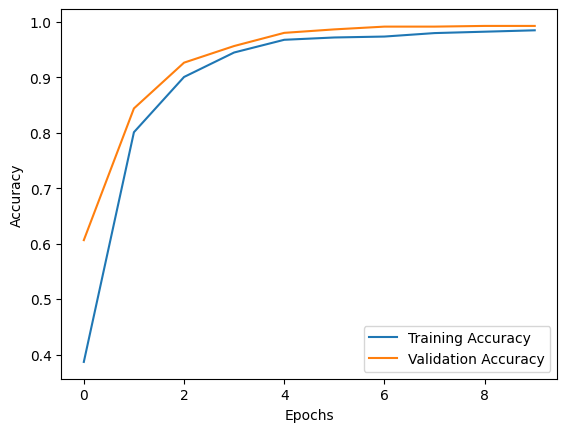

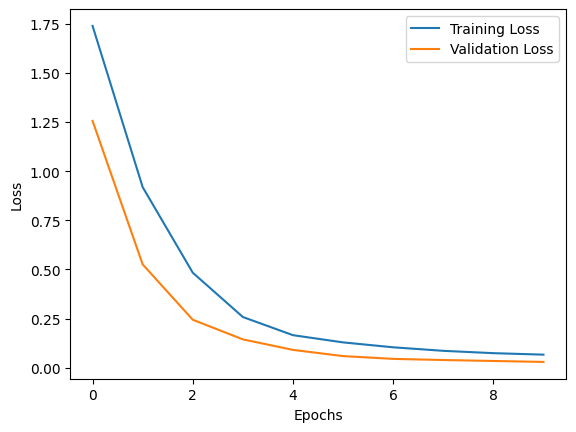

In [11]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step


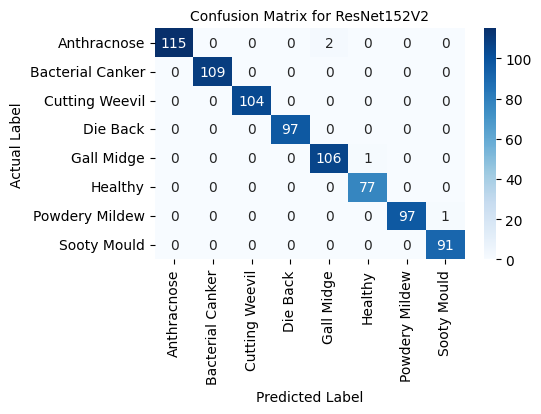

In [24]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for ResNet152V2',fontsize=10)
plt.show()

<Axes: >

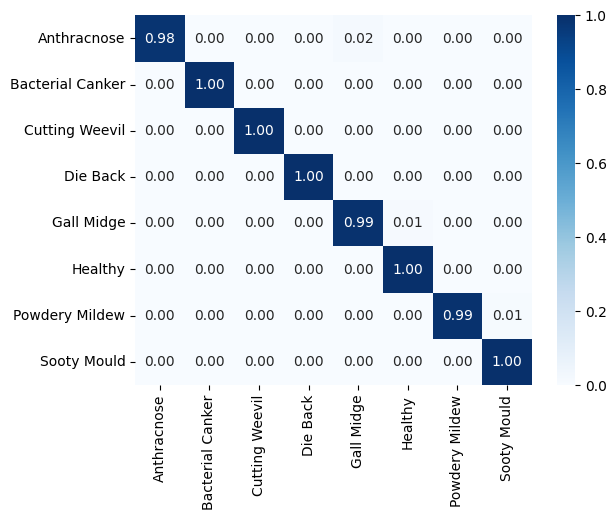

In [35]:
cmn=conf_matrix/conf_matrix.astype(float).sum(axis=1)
sns.heatmap(cmn,annot=True,fmt='.2f',cmap='Blues',xticklabels=class_names,yticklabels=class_names)

In [22]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

model.name="MangoLeaf_ResNet152V2"
model.save('MangoLeaf_ResNet152V2.keras')

#### Modified BatchSize=16, split=60%+20%+20%, targetSize=(128,128,3) lr=.001

In [25]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [26]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df, val_df, test_df, batch_size=16, target_size=(128,128))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [49]:
num_classes=8
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable=False
#inputs=base_model.input
inputs = tf.keras.Input(shape=(128,128,3)) #Define input
x = base_model(inputs,training=False)     #pass input to base model
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs,outputs)  #Create model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [50]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 4, 4, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,438,024 (230.55 MB)

 Trainable params: 2,106,376 (8.04 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [51]:
epochs=10
training_history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.7054 - loss: 1.0696 - val_accuracy: 0.9038 - val_loss: 0.3629
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.8911 - loss: 0.3605 - val_accuracy: 0.9187 - val_loss: 0.2661
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.9281 - loss: 0.2256 - val_accuracy: 0.9075 - val_loss: 0.2897
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.9311 - loss: 0.1733 - val_accuracy: 0.8813 - val_loss: 0.3721
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9313 - loss: 0.1856 - val_accuracy: 0.9137 - val_loss: 0.3044
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9404 - loss: 0.1767 - val_accuracy: 0.9513 - val_loss: 0.1546
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9569 - loss: 0.1290 - val_accuracy: 0.9325 - val_loss: 0.2272
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9616 - loss: 0.1185 - val_accu

In [52]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9391 - loss: 0.2479
Test Loss: 0.17815837264060974, Test Accuracy: 0.9512500166893005


In [53]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step
                  precision    recall  f1-score   support

     Anthracnose       0.90      0.98      0.94       117
Bacterial Canker       0.96      0.95      0.96       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       1.00      0.88      0.93        97
      Gall Midge       0.94      0.89      0.91       107
         Healthy       0.92      1.00      0.96        77
  Powdery Mildew       0.94      0.98      0.96        98
     Sooty Mould       0.97      0.93      0.95        91

        accuracy                           0.95       800
       macro avg       0.95      0.95      0.95       800
    weighted avg       0.95      0.95      0.95       800



50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step


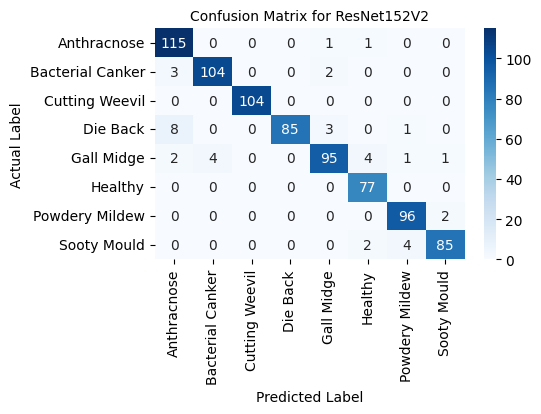

In [55]:
test_predictions=model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for ResNet152V2',fontsize=10)
plt.show()

<Axes: >

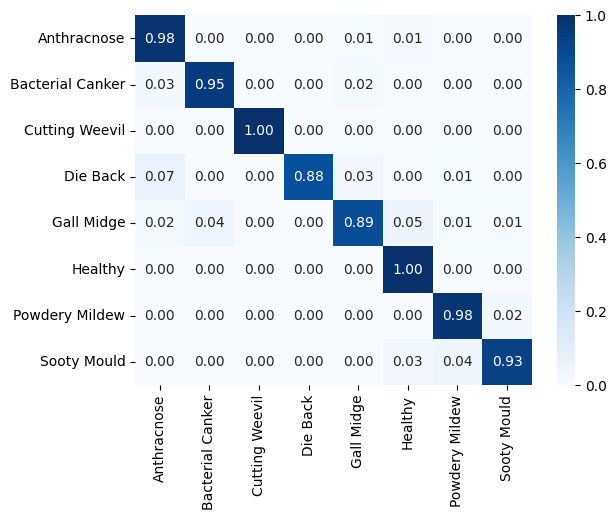

In [56]:
cmn=conf_matrix/conf_matrix.astype(float).sum(axis=1)
sns.heatmap(cmn,annot=True,fmt='.2f',cmap='Blues',xticklabels=class_names,yticklabels=class_names)

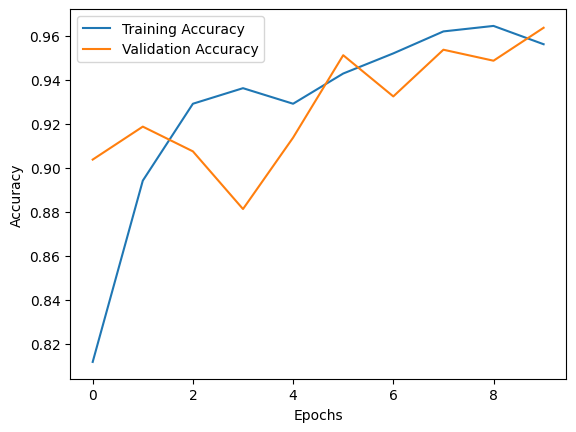

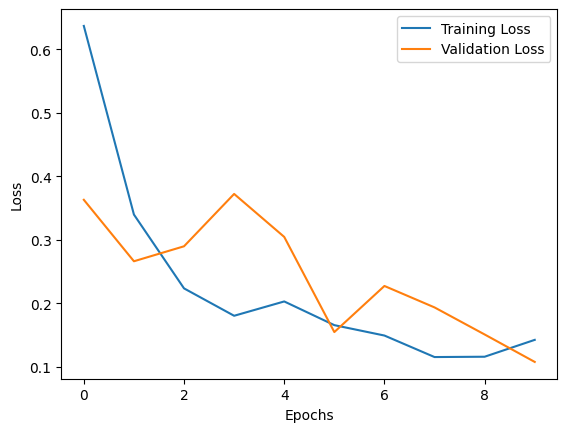

In [57]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()